In [1]:
import numpy as np
import tensorflow as tf
import keras
from IPython.display import Image,display
from keras.applications.vgg19 import VGG19
#import tensornets as nets
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
#from PIL import Image
import numpy as np
import pprint
%matplotlib inline

In [2]:
#import tensorflow as tf
#f#rom tensorflow_core.python.keras.applications.mobilenet_v2 import MobileNetV2
#from tensorflow_core.python.keras.layers.convolutional import Conv2D
#from tensorflow_core.python.keras.models import Model
#import numpy as np
#from tensorflow_core.python.ops.init_ops_v2 import he_normal

#IMG_SIZE = image_size = 224
#IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

#base_model = MobileNetV2(input_shape=IMG_SHAPE,
  #                       include_top=False,
 #                        weights='imagenet')
#base_model.trainable = False
#base_model.summary()
#layer_name = "block_13_expand_relu"
#layer_output = base_model.get_layer(layer_name).output
#x = Conv2D(16,
    #       kernel_size=[3, 3],
   #        strides=[1, 1],
  #         padding='same',
#           kernel_initializer=he_normal(),
 #          activation=tf.nn.relu,
  #         name="conv3",
 #          kernel_regularizer=tf.keras.regularizers.l2(0.01))(layer_output)
#
#model = Model(base_model.input, outputs=[layer_output, x])

#input_data = np.random.rand(1, *IMG_SHAPE)
#result = model.predict(input_data)
#print(result[0].shape)
#print(result[1].shape)

In [3]:
funmodel = VGG19(input_shape=(224,224,3),include_top=False,weights='imagenet')
funmodel.trainable = False
funmodel.summary()
pprint.PrettyPrinter(indent=4).pprint(funmodel) 


Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [5]:
content_image_path = "./images/gimage.png"
style_image_path = "./images/simage.jpg"
width,height = keras.preprocessing.image.load_img(content_image_path).size
nrows = 400
ncols = int(width*nrows/height)


In [6]:
def preprocess_image(img_path):
    img = keras.preprocessing.image.load_img(img_path,target_size=(nrows,ncols))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return tf.convert_to_tensor(img)

def deprocess_image(y):
    y = y.reshape((nrows,ncols,3))
    y[:,:,0] += 103.939
    y[:,:,1] += 116.779
    y[:,:,2] += 123.68
    y = y[:,:,::-1]
    y = np.clip(y,0,255).astype("uint8")
    return y
    
    
    

In [7]:
def compute_content_cost(a_C, a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G (≈2 lines)
    a_C_unrolled = tf.reshape(a_C,shape=[m,-1,n_C])
    a_G_unrolled = tf.reshape(a_G,shape=[m,-1,n_C])
    
    # compute the cost with tensorflow (≈1 line)
    J_content = tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled,a_G_unrolled)))/(4*n_H*n_W*n_C)
    ### END CODE HERE ###
    
    return J_content

In [8]:
def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)
    
    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A,tf.transpose(A))
    ### END CODE HERE ###
    
    return GA

In [9]:
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    ### START CODE HERE ###
    # Retrieve dimensions from a_G (≈1 line)
    m, n_H, n_W, n_C = a_S.get_shape().as_list()
    
    # Reshape the images to have them of shape (n_C, n_H*n_W) (≈2 lines)
    a_S = tf.reshape(tf.transpose(a_S,perm=[0,3,1,2]),shape=[n_C,n_H*n_W])
    a_G = tf.reshape(tf.transpose(a_G,perm=[0,3,1,2]),shape=[n_C,n_H*n_W])

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    J_style_layer = tf.reduce_sum(tf.square(tf.subtract(GS,GG)))/(4*n_C*n_C*n_H*n_H*n_W*n_W)
    
    ### END CODE HERE ###
    
    return J_style_layer

In [10]:
out_dict = dict([(layer.name,layer.output) for layer in funmodel.layers])
feature_extractor = keras.Model(inputs = funmodel.inputs,outputs = out_dict)

In [11]:
style_layers = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]
content_layer = 'block4_conv2'

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # Select the output tensor of the currently selected layer
        out = funmodel.get_layer(layer_name).output

        # Set a_S to be the hidden layer activation from the layer we have selected, by running the session on out
        a_S = sess.run(out)

        # Set a_G to be the hidden layer activation from same layer. Here, a_G references model[layer_name] 
        # and isn't evaluated yet. Later in the code, we'll assign the image G as the model input, so that
        # when we run the session, this will be the activations drawn from the appropriate layer, with G as input.
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [13]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : nrows - 1, : ncols - 1, :] - x[:, 1:, : ncols - 1, :]
    )
    b = tf.square(
        x[:, : nrows - 1, : ncols - 1, :] - x[:, : nrows - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [14]:
def cost_function(cimage,gimage,simage,alpha = 2.5e-8, beta = 1e-6,gamma = 1e-6):
    input_tensor = tf.concat([cimage,simage,gimage],axis=0)
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer]
    cimage_features = layer_features[0,:,:,:]
    gimage_features = layer_features[2,:,:,:]
    cimage_features = tf.expand_dims(cimage_features,axis=0)
    gimage_features = tf.expand_dims(gimage_features,axis=0)
    loss = loss + alpha * compute_content_cost(cimage_features,gimage_features)
    
    for layer in style_layers:
        layer_name,weight = layer
        layer_features = features[layer_name]
        simage_features = layer_features[1,:,:,:]
        gimage_features = layer_features[2,:,:,:]
        simage_features = tf.expand_dims(simage_features,axis=0)
        gimage_features = tf.expand_dims(gimage_features,axis=0)
        loss = loss + beta*weight*compute_layer_style_cost(simage_features,gimage_features)
    #loss = loss + total_variation_loss(gimage_features)*gamma
        
    return loss
    

In [15]:
def compute_loss_grads(cimage,simage,gimage):
    with tf.GradientTape() as diff:
        loss = cost_function(cimage,gimage,simage)
    grads = diff.gradient(loss,gimage)
    return loss, grads
    

In [17]:
optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)
result_prefix="genimg"
content_image = preprocess_image(content_image_path)
style_image = preprocess_image(style_image_path)
gen_image = tf.Variable(preprocess_image(content_image_path))
iterations = 4000

for i in range(1,iterations + 1):
    loss,grads = compute_loss_grads(content_image,style_image,gen_image)
    optimizer.apply_gradients([(grads,gen_image)])
    if i%100 == 0:
        print("Iteration %d: loss=%.2f" % (i, loss))
        img = deprocess_image(gen_image.numpy())
        fname = result_prefix + "_at_iteration_%d.png" % i
        keras.preprocessing.image.save_img(fname, img)
    
display(Image(result_prefix + "_at_iteration_1300.png"))



Iteration 100: loss=99.95
Iteration 200: loss=89.20
Iteration 300: loss=82.94
Iteration 400: loss=78.32
Iteration 500: loss=74.61
Iteration 600: loss=71.52
Iteration 700: loss=68.88
Iteration 800: loss=66.59
Iteration 900: loss=64.58
Iteration 1000: loss=62.80
Iteration 1100: loss=61.22
Iteration 1200: loss=59.79
Iteration 1300: loss=58.50


KeyboardInterrupt: 

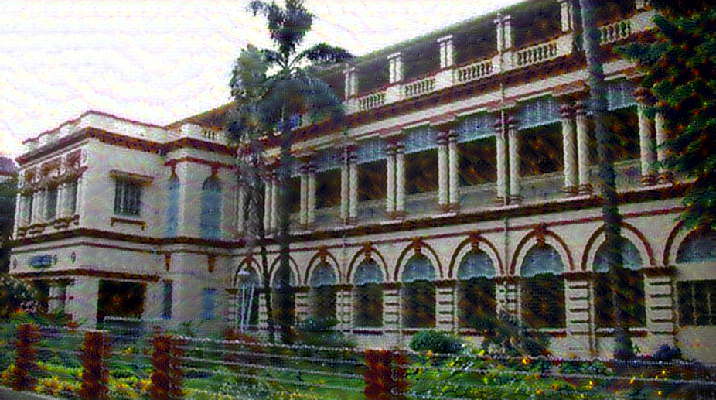

In [19]:
display(Image(content_image_path))
#display(Image(style_image_path))

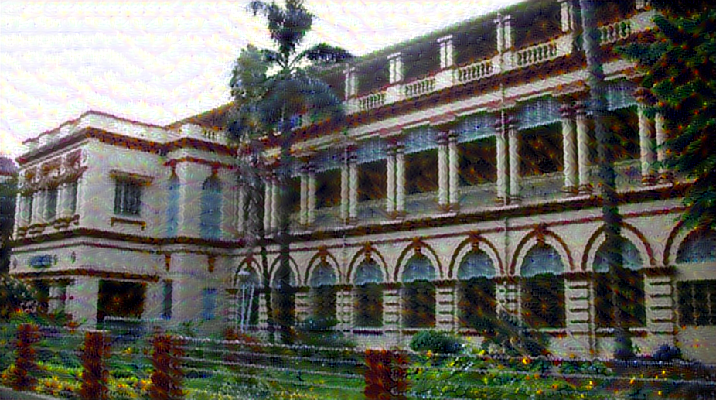

In [18]:
display(Image(result_prefix + "_at_iteration_1300.png"))